In [60]:
from pyleri import (
    Choice,
    Grammar,
    Keyword,
    List,
    Optional,
    Regex,
    Repeat,
    Ref,
    Sequence)

import json

In [61]:

class CircuitJSGrammar(Grammar):
    START = Ref()
    
    #integer_literal = Regex('[0-9]+')    
    #decimal_literal = Regex('([+-]?\d*\.\d+)')
    #exponential_literal = Regex('(\d*\.\d+|\d+)(e[+-]?\d+)?')

    #exponential_or_decimal_literal = Choice(exponential_literal, decimal_literal)
    #integer_or_decimal_literal = Choice(integer_literal, decimal_literal)
    number_literal = Regex('[-+]?[0-9]*\.?[0-9]+([eE][-+]?[0-9]+)?')
    two_terminal_coords = Repeat(number_literal, mi=4, ma=4)
    booly = Choice(Keyword('true'), Keyword('false'))

    capacitor = Sequence(Keyword('c'), two_terminal_coords, number_literal, number_literal, Repeat(number_literal, mi=2, ma=2))
    ground = Sequence(Keyword('g'), two_terminal_coords, Repeat(number_literal, mi=2, ma=2))    
    inductor = Sequence(Keyword('l'),  two_terminal_coords, number_literal, number_literal, Repeat(number_literal, mi=2, ma=2))
    resistor = Sequence(Keyword('r'), two_terminal_coords, number_literal, number_literal)
    switch = Sequence(Keyword('s'), two_terminal_coords, number_literal, number_literal, booly)
    voltage = Sequence(Keyword('v'), two_terminal_coords, Repeat(number_literal, mi=3, ma=3), number_literal, Repeat(number_literal, mi=2, ma=2), number_literal)
    wire = Sequence(Keyword('w'), two_terminal_coords, number_literal)


    START = Choice(capacitor, ground, inductor, resistor, switch, voltage, wire)
    #START = Choice(capacitor, resistor, switch, voltage, wire)

def node_props(node, children):
    return {
        'start': node.start,
        'end': node.end,
        'name': node.element.name if hasattr(node.element, 'name') else None,
        'element': node.element.__class__.__name__,
        'string': node.string,
        'children': children
    }


# Recursive method to get the children of a node object:
def get_children(children):
    return [node_props(c, get_children(c.children)) for c in children]


# View the parse tree:
def view_parse_tree(res):
    start = res.tree.children[0] \
        if res.tree.children else res.tree
    return node_props(start, get_children(start.children))
        
grammar = CircuitJSGrammar()
print(grammar.parse('r 240 80 448 80 0 10').is_valid)
res = grammar.parse('r 240 80 448 80 0 10')
print(json.dumps(view_parse_tree(res), indent=2))
#print(grammar.parse('v 32 288 32 224 0 0 40 12 0 0 0.5').is_valid)

#res = grammar.parse('c 368 64 368 144 0 1e-7 0.001 0.001')
#print(res.is_valid)
#print(res.pos)


True
{
  "start": 0,
  "end": 20,
  "name": "START",
  "element": "Ref",
  "string": "r 240 80 448 80 0 10",
  "children": [
    {
      "start": 0,
      "end": 20,
      "name": "resistor",
      "element": "Sequence",
      "string": "r 240 80 448 80 0 10",
      "children": [
        {
          "start": 0,
          "end": 1,
          "name": null,
          "element": "Keyword",
          "string": "r",
          "children": []
        },
        {
          "start": 2,
          "end": 15,
          "name": "two_terminal_coords",
          "element": "Repeat",
          "string": "240 80 448 80",
          "children": [
            {
              "start": 2,
              "end": 5,
              "name": "number_literal",
              "element": "Regex",
              "string": "240",
              "children": []
            },
            {
              "start": 6,
              "end": 8,
              "name": "number_literal",
              "element": "Regex",
             

In [62]:
class ComponentWarehouse:
    def __init__(self):
        self.classes = {}

    def add_class(self, c):
        self.classes[c.__name__] = c

    # -- the decorator
    def component(self, c):
        self.add_class(c)

        # Decorators have to return the function/class passed (or a modified variant thereof), however I'd rather do this separately than retroactively change add_class, so.
        # "held" is more succint, anyway.
        return c 

    def __getitem__(self, n):
        return self.classes[n]

component_warehouse = ComponentWarehouse()

#@food_types.held
#class chocolate:
#    taste = "sweet"

#@food_types.held
#class lemon:
#    taste = "sour"

#print(food_types['chocolate'].taste) # No manual add_class needed! :D


In [63]:
import schemdraw
import schemdraw.elements as elm

In [64]:
class ElectricComponent(object):
    
    id = 1

    def __init__(self):
        self._direction = 'up'

    @property
    def direction(self):
        return self._direction

    @direction.setter
    def direction(self, direction):
        self._direction = direction

    @property
    def hasValue(self):
        return True

    @property
    def anchor(self):
        return ['start', 'end']

    @property
    def hasLabel(self):
        return True

    @property
    def getLabel(self):
        return self.id

    @property
    def isDirectional(self):
        return False
    

class TwoTerminalComponent(ElectricComponent):
    def setValue(self, parsing_element):
        self._value = parsing_element[3].string
        print(self._value)
        

@component_warehouse.component
class capacitor(TwoTerminalComponent):
    def getElement(self):
        return elm.Capacitor()

    @property
    def labelPrefix(self):
        return "C"

    @property
    def valueUnits(self):
        return "F"

@component_warehouse.component
class ground(ElectricComponent):
    def getElement(self):
        return elm.Ground()

    @property
    def hasValue(self):
        return False

    @property
    def hasLabel(self):
        return False

@component_warehouse.component
class resistor(TwoTerminalComponent):
    def getElement(self):
        return elm.Resistor()

    @property
    def labelPrefix(self):
        return "R"

    @property
    def valueUnits(self):
        return "Ω"

@component_warehouse.component
class inductor(TwoTerminalComponent):
    def getElement(self):
        return elm.Inductor()

@component_warehouse.component
class switch(TwoTerminalComponent):
    def getElement(self):
        return elm.Switch()

    @property
    def hasValue(self):
        return False

    @property
    def hasLabel(self):
        return False    

@component_warehouse.component
class voltage(TwoTerminalComponent):
    def getElement(self):
        return elm.SourceV()

    @property
    def labelPrefix(self):
        return "V"

    @property
    def valueUnits(self):
        return "V"

    @property
    def isDirectional(self):
        return True

@component_warehouse.component
class wire(ElectricComponent):
    def getElement(self):
        return elm.Line()

    @property
    def hasValue(self):
        return False

    @property
    def hasLabel(self):
        return False


r 176 80 384 80 0 10

True
resistor
<class '__main__.resistor'>
[('176', '80'), ('384', '80')]
('176', '80') ('384', '80')
right
1
True
10
--------------------
s 384 80 448 80 0 1 false

True
switch
<class '__main__.switch'>
[('384', '80'), ('448', '80')]
('384', '80') ('448', '80')
right
1
False
--------------------
w 176 80 176 352 0

True
wire
<class '__main__.wire'>
[('176', '80'), ('176', '352')]
('176', '80') ('176', '352')
down
1
False
--------------------
c 384 352 176 352 0 0.000015 2.7575650952626365 -10

True
capacitor
<class '__main__.capacitor'>
[('384', '352'), ('176', '352')]
('384', '352') ('176', '352')
left
1
True
0.000015
--------------------
l 384 80 384 352 0 1 -0.03831979262825636 0

True
inductor
<class '__main__.inductor'>
[('384', '80'), ('384', '352')]
('384', '80') ('384', '352')
down
1
True
1
--------------------
v 448 352 448 80 0 0 40 5 0 0 0.5

True
voltage
<class '__main__.voltage'>
[('448', '352'), ('448', '80')]
('448', '352') ('448', '80')
up
1
True
5

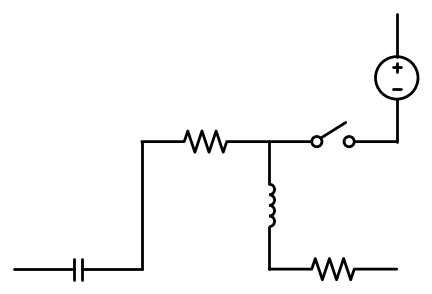

In [65]:
from collections import defaultdict

def getCoordinates(parsing_element):
    coords = parsing_element.split()
    return [(coords[0], coords[1]),(coords[2], coords[3])]

def getDirection(coords):
    first_terminal, second_terminal = coords 
    x1,y1 = first_terminal
    x2,y2 = second_terminal
    diff_x = int(x1) - int(x2)
    diff_y = int(y1) - int(y2)

    match (diff_x, diff_y):
        case (0, diff_y) if diff_y < 0:
            return 'down'
        case (0, diff_y) if diff_y > 0:
            return 'up'
        case (diff_x, 0) if diff_x < 0:
            return 'right'
        case (diff_x, 0) if diff_x > 0:
            return 'left'
        case _:
            return 'up'


component_list = []
element_list = []
lookup = defaultdict(list)

with open('tests/basic2.txt') as f:
#with open('tests/basic.txt') as f:
#with open('tests/sample2.txt') as f:
    f.readline()
    for line in f:
        print(line)
        parsing_result = grammar.parse(line)
        print(parsing_result.is_valid)
        if parsing_result.is_valid:
            FIRST_CHILD = 0
            start = parsing_result.tree.children[FIRST_CHILD].children[FIRST_CHILD]
            component_parameters = start.children[FIRST_CHILD]
            component_name = start.element.name
            coordinates = start.children[1].string
            print(component_name)
            print(component_warehouse[component_name])
            terminal_coords = getCoordinates(coordinates)
            print(terminal_coords)
            start_coords, end_coords = terminal_coords
            print(start_coords, end_coords)
            
            direction = getDirection(terminal_coords)
            print(direction)
            component = component_warehouse[component_name]()
            
            component.direction = direction
            print(component.id)
            print(component.hasValue)


            element = None
            if component.hasValue:
                component.setValue(start.children)                

            element = component.getElement()
            #element = getattr(element, direction)()
            print(element)


            component_list.append(element)
            element_list.append({
                'anchor_start': start_coords,
                'anchor_end': end_coords,
                'element': element,
                'component': component
            })
            lookup[start_coords].append((element, 'start'))
            lookup[end_coords].append((element, 'end'))
            print('--------------------')

print(component_list)
print(element_list)
print(lookup)


#i=0
#while i<len(element_list):
   


import schemdraw
import schemdraw.elements as elm


with schemdraw.Drawing() as d:
    first_element = element_list[0]
    anchor_start = first_element['anchor_start']
    anchor_end = first_element['anchor_end']
    lookup2 = {}
    lookup2[anchor_start] = (first_element['element'], 'start')
    lookup2[anchor_end] = (first_element['element'], 'end')
    print("----lookup2---")
    print(lookup2)

    d += first_element['element']

    i = 1
    current = anchor_end
    

    while i < len(element_list):
        element = element_list[i]
        anchor_start = element['anchor_start']
        anchor_end = element['anchor_end']
        e = element['element']
        component = element['component']

        e = getattr(e, component.direction)()
        if anchor_start in lookup2:
            f,g = lookup2[anchor_start]
            d += e.at(getattr(f, g))
            i = i + 1
            lookup2[anchor_start] = (e, 'start')
            lookup2[anchor_end] = (e, 'end')


        elif anchor_end in lookup2:
            f,g = lookup2[anchor_end]
            d += e.at(getattr(f, g))
            i = i + 1
            lookup2[anchor_start] = (e, 'start')
            lookup2[anchor_end] = (e, 'end')            

        else:
            pass 
#with schemdraw.Drawing() as d:
#    for c in component_list:
#        d += c




In [66]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

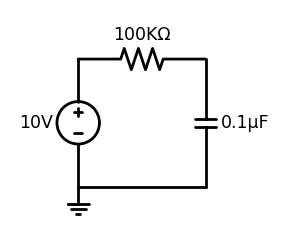

In [67]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += elm.SourceV().label('10V')
    d += elm.Resistor().right().label('100KΩ')
    d += elm.Capacitor().down().label('0.1μF', loc='bottom')
    d += elm.Line().left()
    d += elm.Ground()
    


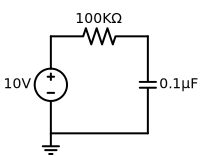

In [68]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing(show=True, backend='svg') as d:
    d += elm.SourceV().label('10V')
    d += elm.Resistor().right().label('100KΩ')
    d += elm.Capacitor().down().label('0.1μF', loc='bottom')
    d += elm.Line().left()
    d += elm.Ground()

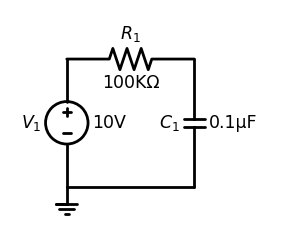

In [69]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += elm.SourceV().label('10V', loc='bottom').label('$V_1$', loc='top')
    d += elm.Resistor().right().label('100KΩ', loc='bottom').label('$R_1$', loc='top')
    d += elm.Capacitor().down().label('0.1μF', loc='bottom').label('$C_1$', loc='top')
    d += elm.Line().left()
    d += elm.Ground()

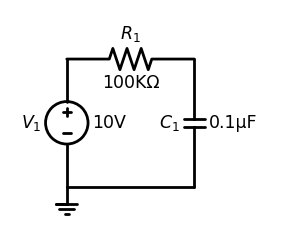

In [70]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up')
    d += elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right')
    d += elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='down')
    d += elm.Line(d='left')
    d += elm.Ground()

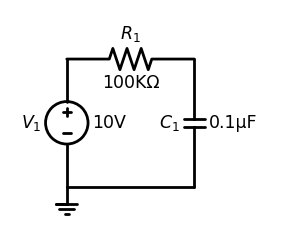

In [71]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up'))
    d += elm.Ground().at(battery.start)
    d += elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right').at(battery.end)
    d += (line := elm.Line(d='right').at(battery.start))
    d += elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='up').at(line.end)
    
    

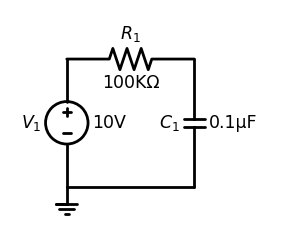

In [72]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up'))
    d += elm.Ground(at=getattr(battery, 'start'))
    d += elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right', at=getattr(battery, 'end'))
    d += (line := elm.Line(d='right', at=getattr(battery, 'start')))
    d += elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='up' , at=getattr(line, 'end'))
    
    

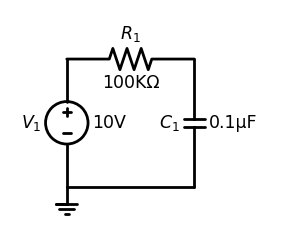

In [73]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up'))    
    d += (resistor := elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right', at=getattr(battery, 'end')))
    d += elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='down' , at=getattr(resistor, 'end'))
    d += (line := elm.Line(d='right', at=getattr(battery, 'start')))
    d += elm.Ground(at=getattr(line, 'start'), d='right')

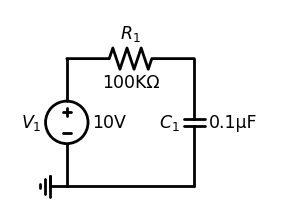

In [74]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up'))    
    d += (resistor := elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right', at=getattr(battery, 'end')))
    d += elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='down' , at=getattr(resistor, 'end'))
    d += (line := elm.Line(d='right', at=getattr(battery, 'start')))
    d += elm.Ground(at=getattr(line, 'start'), d='down')

Point(0,0)
Point(1.8369701987210297e-16,3.0)
{'outfile': None, 'backend': None, 'show': True, 'elements': [<schemdraw.elements.sources.SourceV object at 0x0000017737311190>], 'dwgparams': {'unit': 3.0, 'inches_per_unit': 0.5, 'lblofst': 0.1, 'fontsize': 14, 'font': 'sans-serif', 'color': 'black', 'lw': 2, 'ls': '-', 'fill': None}, 'unit': 3.0, 'here': Point(1.8369701987210297e-16,3.0), 'theta': 90, '_state': [], '_interactive': False, 'fig': None}
Point(3.0,3.0)
Point(2.9999999999999996,0.0)
Point(0.0,3.6739403974420594e-16)
Help on method move in module schemdraw.schemdraw:

move(dx: 'float' = 0, dy: 'float' = 0) -> 'None' method of schemdraw.schemdraw.Drawing instance
    Move the current drawing position
    
    Args:
        dx: change in x position
        dy: change in y position

None
Help on method move_from in module schemdraw.schemdraw:

move_from(ref: 'Point', dx: 'float' = 0, dy: 'float' = 0, theta: 'float' = None) -> 'None' method of schemdraw.schemdraw.Drawing instance
 

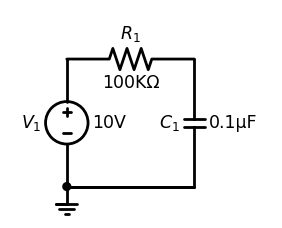

In [75]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    print(d.here)
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up'))    
    print(d.here)
    print(d.__dict__)
    d += (resistor := elm.Resistor(botlabel='100KΩ', toplabel='$R_1$', d='right', at=getattr(battery, 'end')))
    print(d.here)
    d += (capacitor := elm.Capacitor(botlabel='0.1μF', toplabel='$C_1$', d='down' , at=getattr(resistor, 'end')))
    print(d.here)
    d += (line := elm.Line(d='right', at=getattr(battery, 'start')))
    d += (line := elm.Line(d='left'))
    d += elm.Dot()
    print(d.here)
    print(help(d.move))
    print(help(d.move_from))
    
    d += elm.Ground(at=getattr(line, 'end'), d='right')

Point(0.0,0.0) Point(1.8369701987210297e-16,3.0)


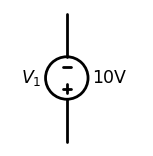

In [76]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (battery := elm.SourceV(botlabel='10V', toplabel='$V_1$', d='up', reverse=True))
    print(battery.start, battery.end)


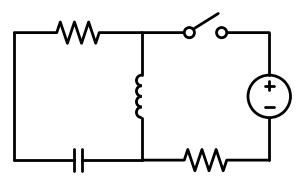

In [77]:
import schemdraw
import schemdraw.elements as elm

with schemdraw.Drawing() as d:
    d += (resistor := elm.Resistor(d='right'))
    d += (switch := elm.Switch(d='right'))
    d += (wire1 := elm.Line(d='down', at=resistor.start))
    d += (capacitor := elm.Capacitor(d='right', at=wire1.end))
    d += (voltage := elm.SourceV(d='down', at=switch.end, reverse=True))
    d += (resistor2 := elm.Resistor(d='left', at=voltage.end))
    d += (inductor := elm.Inductor(d='up', at=resistor2.end))
